## **Land usage classification in Agriculture**


We will explore how land use types can be classified based on aerial and satellite photographs of the earth's surface. We will learn to build our own photo masks based on ready-made masks and display them on the screen.


## Introduction


Determining how land is used is a huge problem today. After all, its improper and illegal use can lead to both economic and natural disasters. One of the ways to assess the use is the analysis of aerial and satellite images of the earth's surface. A big problem is to build a mathematical model that can determine the type of land use based on colors. If you have ready-made photos and masks of land use, you can use the methods of artificial intelligence and big data to build a model-classifier.


## Import the required libraries 


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import json
from PIL import Image
from colormap import rgb2hex, hex2rgb

#Classifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import ConfusionMatrixDisplay

## Loading of data


In [8]:
import skillsnetwork

await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/data-science-in-agriculture-land-use-classification/Semantic_segmentation_dataset.zip", overwrite=True)

  0%|          | 0/333 [00:00<?, ?it/s]

Saved to '.'


In [11]:
def get_data(folder, file):
    # download json
    f = open(folder + "/" + file,)
    data = json.load(f)
    f.close()
    cl = {}
    # Create a dictionary with classes
    for i, c in enumerate(data['classes']):
        cl[i] = dict(c)
        
    for k, v in cl.items():
        print('Class', k)
        for k2, v2 in v.items():
            print("   ", k2, v2)
    data = []
    
    # download images
    sd = [item for item in os.listdir(folder) if os.path.isdir(folder + '/' + item)] # a list of subdirectories
    print("Subdirectories: ", sd)
    for f in sd[1:2]: #choose one of the subdirectories to download
        print("Downloading: ", f)
        images = glob(folder + "/" + f + "/images" + "/*.jpg") # create a list of image files
        for im in images:
            mask_f = im.replace("images", "masks").replace("jpg", "png") # create a list of mask files
            image = Image.open(im) 
            mask = Image.open(mask_f)
            if len(np.array(mask).shape) > 2:
                data.append([image, mask])
        fig = plt.figure(figsize = (10,10)) #display the last image + mask
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()

    return (data)

Class 0
    title Water
    shape polygon
    color #50E3C2
    geometry_config {}
Class 1
    title Land (unpaved area)
    shape polygon
    color #F5A623
    geometry_config {}
Class 2
    title Road
    shape polygon
    color #DE597F
    geometry_config {}
Class 3
    title Building
    shape polygon
    color #D0021B
    geometry_config {}
Class 4
    title Vegetation
    shape polygon
    color #417505
    geometry_config {}
Class 5
    title Unlabeled
    shape polygon
    color #9B9B9B
    geometry_config {}
Subdirectories:  ['Tile 8', 'Tile 6', 'Tile 3', 'Tile 5', 'Tile 1', 'Tile 4', 'Tile 7', 'Tile 2']
Downloading:  Tile 6


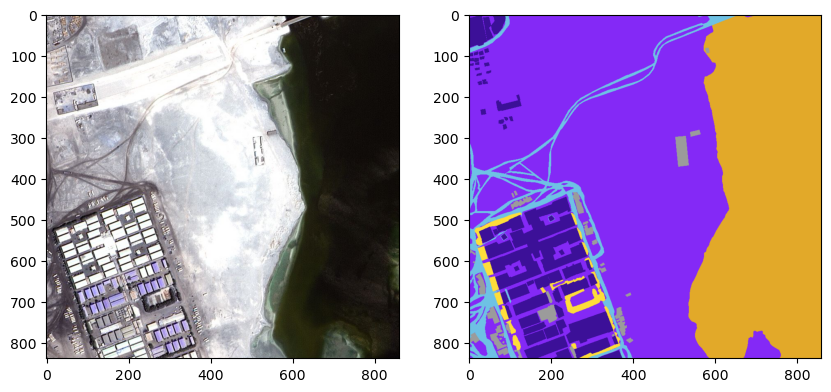

In [12]:
d = "Semantic segmentation dataset"
f = "classes.json"
data = get_data(d, f)

As you can see, the csv file contains a description of 6 land use classes. Each class has its own color in the mask file.
We downloaded all the pictures and their masks from a separate directory and formed a set of data lists consisting of tuples of picture-mask.


# DataSet creation


Let's see how many images we downloaded:


In [13]:
len(data)

9

In [14]:
def create_DataSet(data):
    DS = pd.DataFrame()
    for image, mask in data:
        # transform image to matrix
        im = np.asarray(image) 
        mk = np.asarray(mask)
        # transform a one-dimension array of r, g, b colors
        red = im[:,:,0].flatten()
        green = im[:,:,1].flatten()
        blue = im[:,:,2].flatten()
        im_f = np.array([red, green, blue])
        red = mk[:,:,0].flatten()
        green = mk[:,:,1].flatten()
        blue = mk[:,:,2].flatten()
        # calculate hex classes
        h = np.array([rgb2hex(*m) for m in zip(red, green, blue)])
        mk_f = np.array([red, green, blue, h])      
        d = np.concatenate((im_f, mk_f), axis=0)
        # create a DataSet
        DS_new = pd.DataFrame(np.transpose(d), columns = ['Im_Red', 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue', 'HEX'])
        if len(DS) == 0:
            DS = DS_new
        else:
            DS = DS.append(DS_new)
    return DS

In [15]:
print("Create a training DataSet")
train = create_DataSet(data[:4])
print(train)
print("Create test DataSet")
test = create_DataSet(data[4:])
print(test)

Create a training DataSet
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0          58       64      64    254      221      58  #FEDD3A
1          35       41      41    254      221      58  #FEDD3A
2          45       51      51    254      221      58  #FEDD3A
3          58       64      64    254      221      58  #FEDD3A
4          68       74      74    254      221      58  #FEDD3A
...       ...      ...     ...    ...      ...     ...      ...
719837     93       98     101    132       41     246  #8429F6
719838    100      105     108    132       41     246  #8429F6
719839     95      100     103    132       41     246  #8429F6
719840     83       88      91    132       41     246  #8429F6
719841     91       96      99    132       41     246  #8429F6

[2879368 rows x 7 columns]
Create test DataSet
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0           1        1       3    226      169      41  #E2A929
1           1        1       3

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879368 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 175.7+ MB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599210 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 219.7+ MB


As you can see, all the columns have object type. 

The last column 'HEX' contains colors in hex format. Therefore, it is necessary to change the type of this data to categorical.


In [18]:
train.loc[:, 'HEX'] = train['HEX'].astype('category')
train['HEX']

0         #FEDD3A
1         #FEDD3A
2         #FEDD3A
3         #FEDD3A
4         #FEDD3A
           ...   
719837    #8429F6
719838    #8429F6
719839    #8429F6
719840    #8429F6
719841    #8429F6
Name: HEX, Length: 2879368, dtype: category
Categories (5, object): ['#000000', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

In [19]:
test.loc[:, 'HEX'] = test['HEX'].astype('category')
test['HEX']

0         #E2A929
1         #E2A929
2         #E2A929
3         #E2A929
4         #E2A929
           ...   
719837    #E2A929
719838    #E2A929
719839    #E2A929
719840    #E2A929
719841    #E2A929
Name: HEX, Length: 3599210, dtype: category
Categories (7, object): ['#000000', '#3C1098', '#6EC1E4', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

All other columns contain colors in int format, therefore we should change their types:


In [20]:
cl = ['Im_Red', 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue']
train[cl] = train[cl].astype('int64')
test[cl] = test[cl].astype('int64')
print (train.info())
print (test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879368 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 156.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599210 entries, 0 to 719841
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 195.7 MB
None


Let’s visualize our data and see what exactly we are working with. We use seaborn to plot the number of pixel classes and you can see what the output looks like.


<AxesSubplot:xlabel='HEX', ylabel='count'>

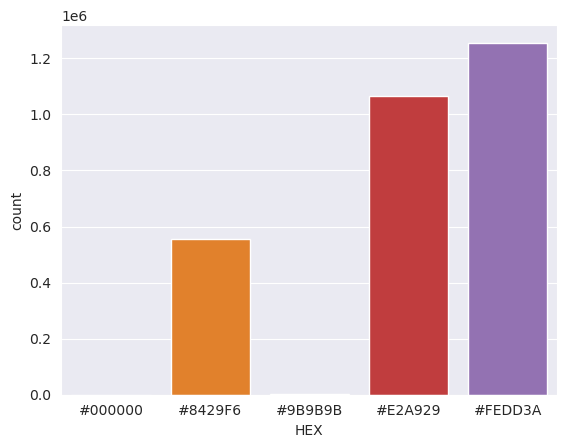

In [21]:
c = pd.DataFrame(train['HEX'])
sns.set_style('darkgrid')
sns.countplot(x="HEX", data=c)

<AxesSubplot:xlabel='HEX', ylabel='count'>

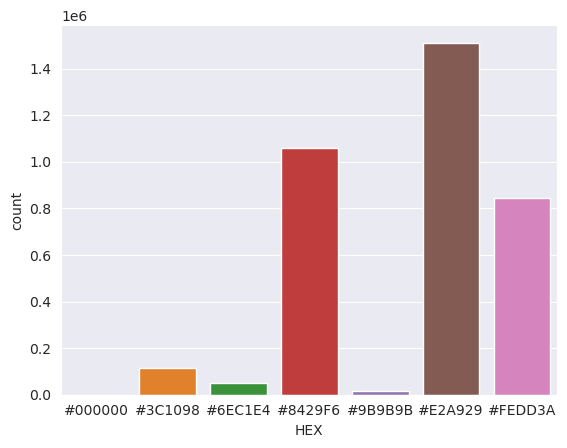

In [22]:
c = pd.DataFrame(test['HEX'])
sns.set_style('darkgrid')
sns.countplot(x="HEX", data=c)

As you can see, the DataSet consist of 6 land use classes. 


The training and test DataSets contain similar distribution of images classes.


# Classification model creation


We will use **[sklearn.linear_model.LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)** classifier for mask analysis. It is a very fast and simple classifier. In the next lab we will compare different classifiers.

We will use first 3 columns (RGB of image pixel) as imput parameters, and the last column (HEX color of mask picture) as an output.

The **[fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01&highlight=logisticregression#sklearn.linear_model.LogisticRegression.fit)** and **[score()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.score)** functions are used for training and evaluating the accuracy.


We will use function **[ConfusionMatrixDisplay.from_estimator()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)** for analysis.


In [23]:
clf = LogisticRegression(max_iter=100, n_jobs=-1)
c = train.columns
clf.fit(train[c[0:3]], train[c[-1:]].values.ravel())

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(n_jobs=-1)

Accuracy train DataSet:  89.4% Accuracy test DataSet:  80.6%


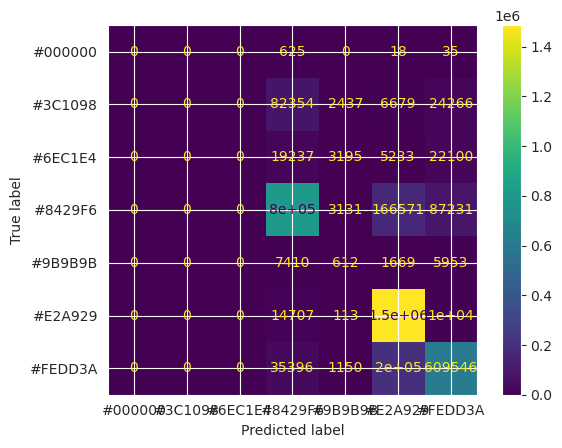

In [24]:
scores_train = clf.score(train[c[0:3]], train[c[-1:]].values.ravel())
scores_test = clf.score(test[c[0:3]], test[c[-1:]].values.ravel())
print('Accuracy train DataSet: {: .1%}'.format(scores_train), 'Accuracy test DataSet: {: .1%}'.format(scores_test))
ConfusionMatrixDisplay.from_estimator(clf, test[c[0:3]], test[c[-1:]].values.ravel())  
plt.show()

As you can see, the accuracy is not bad. The difference between the training and test sets is little. It means that the model is not bad, and for increasing the accuracy we should increase our DataSet. You can test it yourself by adding all the directories with images.


# Create our own mask of land use


Let's build our own mask based on our classifier model.

First of all, we need to choose a few images from the downloaded data list and build your DataSet.


In [25]:
test_image = 8 # choose the number of images from the data list
mask_test = data[test_image:test_image+1] # Test Image + Mask
mask_test_DataSet = create_DataSet(mask_test) #Build a DataSet
print(mask_test_DataSet)

       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0         142      135     151    132       41     246  #8429F6
1         134      127     143    132       41     246  #8429F6
2         102       96     110    132       41     246  #8429F6
3         117      111     125    132       41     246  #8429F6
4         125      119     131    132       41     246  #8429F6
...       ...      ...     ...    ...      ...     ...      ...
719837      9        7      10    226      169      41  #E2A929
719838     12       10      13    226      169      41  #E2A929
719839      8        6       9    226      169      41  #E2A929
719840      8        6       9    226      169      41  #E2A929
719841      8        6       9    226      169      41  #E2A929

[719842 rows x 7 columns]


Then, calculate the hex colour of classes using our model:


In [26]:
c = mask_test_DataSet.columns
mask_test_predict = clf.predict(mask_test_DataSet[c[0:3]])
print(mask_test_predict)

['#FEDD3A' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']


Further, we need to transform the 1D array of colors into a 2D matrix of Hex color using **[numpy.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**. 


In [27]:
size = mask_test[0][1].size #get original image size
print(size)
predict_img = np.array(mask_test_predict).reshape((size[1], size[0])) #reshaping array of HEX colour
print(predict_img)

(859, 838)
[['#FEDD3A' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#FEDD3A' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#8429F6' '#8429F6' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ...
 ['#FEDD3A' '#FEDD3A' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#FEDD3A' '#E2A929' '#FEDD3A' ... '#E2A929' '#E2A929' '#E2A929']
 ['#FEDD3A' '#E2A929' '#E2A929' ... '#E2A929' '#E2A929' '#E2A929']]


Than we create a 3D image matrix with an RGB colour map using **[colormap.hex2rgb()](https://pythonhosted.org/colormap/references.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsdatascienceinagriculturelanduseclassification462-2022-01-01)**.


In [28]:
rgb_size = np.array(mask_test[0][0]).shape
print("Image size: ", rgb_size)
predict_img_rgb = np.zeros(rgb_size)
for i, r in enumerate(predict_img):
    for j, c in enumerate(r):
        predict_img_rgb[i, j, 0], predict_img_rgb[i, j, 1], predict_img_rgb[i, j, 2] = hex2rgb(c)

Image size:  (838, 859, 3)


Let's compare our mask with the original one.


Model mask


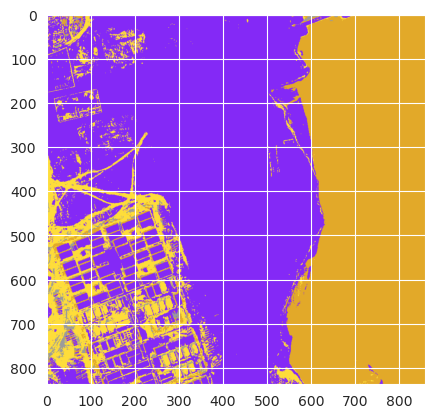

Real mask


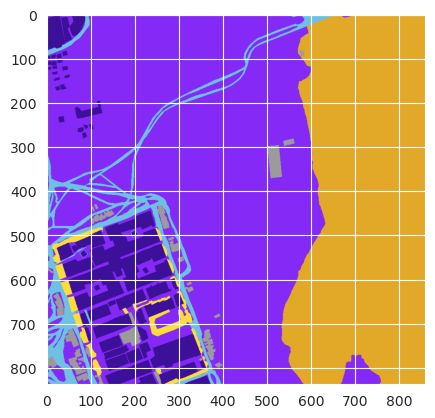

In [29]:
predict_img_rgb = predict_img_rgb.astype('int')
print("Model mask")
plt.imshow(predict_img_rgb)
plt.show()
print("Real mask")
plt.imshow(mask_test[0][1])
plt.show()

You can see that these masks are very similar and you just have to increase the DataSets to improve the accuracy.


## Conclusions


We studied how to create an expert system based on classifiers that classifies land using aerial and satellite images. These principles apply to any type of images and land use.

We learned to upload and convert images, mastered extracting image colors, and built, trained, and tested sets of classifiers. We calculated accuracy and built our own masks using a classifier.